# Training a Pix2Pix Model

This section outlines the process of training the Pix2Pix model to translate land cover maps into corresponding satellite images. The training involves preparing the dataset, building the model architecture with a generator and discriminator, and optimizing it through iterative learning. By using paired images of land cover and satellite data, the model learns to generate realistic satellite images that correspond to given land cover inputs. This step is essential for enabling the model to learn the relationship between land cover and satellite imagery, ensuring it can produce accurate and realistic outputs for various landscapes.

## Step 1

<strong style="color: #CD6AA3;">First, we need to transform and prepare the datasets used in training/testing.</strong> In this step, we begin with concatenating images from the land cover image folder and satellite image folder by same names. Then, we separate these images into three folders – training, validation and test by an 8:1:1 proportion. After which we jitter these images randomly to adjust to the needs of a Pix2Pix model, and store these images in train_dataset and test_dataset.

In [32]:
#| code-fold: true

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from PIL import Image
import pandas as pd
import altair as alt

In [ ]:
#| eval: false

lc_dir = '24-1204_training_images_2/LC'
tc_dir = '24-1204_training_images_2/RC'
training_dir = '24-1204_training_images_2/training'
val_dir = '24-1204_training_images_2/validation'
test_dir = '24-1204_training_images_2/test'

os.makedirs(training_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

all_filenames = [f for f in os.listdir(lc_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
np.random.shuffle(all_filenames)  

num_images = len(all_filenames)
num_val = int(num_images * 0.1)
num_test = int(num_images * 0.1)

val_filenames = all_filenames[:num_val]
test_filenames = all_filenames[num_val:num_val + num_test]
train_filenames = all_filenames[num_val + num_test:]

def process_and_save_images(filenames, target_dir):
    for filename in filenames:
        lc_path = os.path.join(lc_dir, filename)
        tc_name = filename.replace('_pillow', '')  
        tc_path = os.path.join(tc_dir, tc_name)

        if os.path.exists(tc_path):
            lc_image = Image.open(lc_path).resize((256, 256))
            tc_image = Image.open(tc_path).resize((256, 256))

            combined_image = Image.new('RGB', (512, 256))  
            combined_image.paste(lc_image, (0, 0))
            combined_image.paste(tc_image, (256, 0))

            output_path = os.path.join(target_dir, tc_name)
            combined_image.save(output_path)

            print(f'Saved combined image: {output_path}')
        else:
            print(f'Image not found for: {tc_name}')

process_and_save_images(val_filenames, val_dir)
process_and_save_images(test_filenames, test_dir)
process_and_save_images(train_filenames, training_dir)

(256, 512, 3)


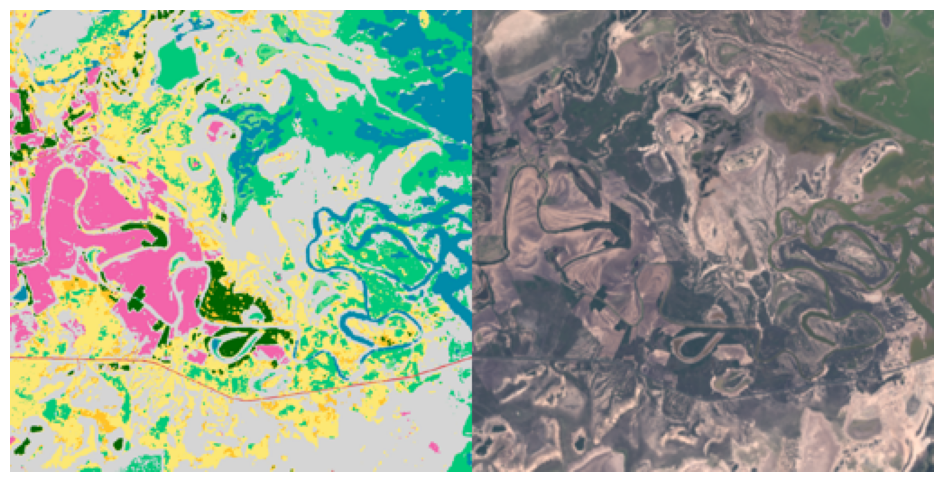

In [4]:
sample_path = '24-1204_training_images_2/training'
sample_files = os.listdir(sample_path)
sample_image = tf.io.read_file(os.path.join(sample_path, sample_files[0]))
sample_image = tf.io.decode_jpeg(sample_image)

print(sample_image.shape)
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.imshow(sample_image)
ax.axis('off') 
plt.show()

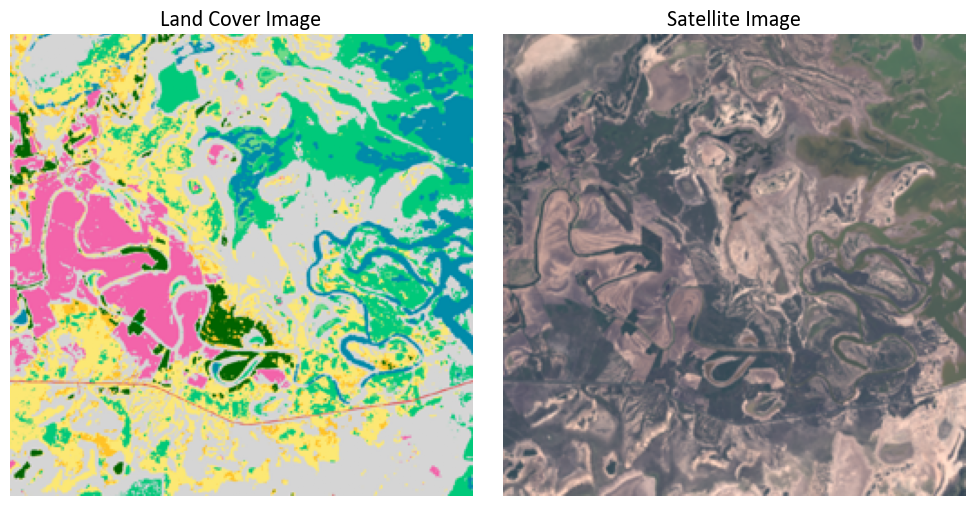

In [5]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real color satellite image
    # - one with a land cover image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

inp, re = load(os.path.join(sample_path, sample_files[0]))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
axes[0].imshow(inp / 255.0)
axes[0].axis('off')  
axes[0].set_title("Land Cover Image", fontsize=16, family="Calibri")

axes[1].imshow(re / 255.0)
axes[1].axis('off')  
axes[1].set_title("Satellite Image", fontsize=16, family="Calibri")

plt.tight_layout()
plt.show()

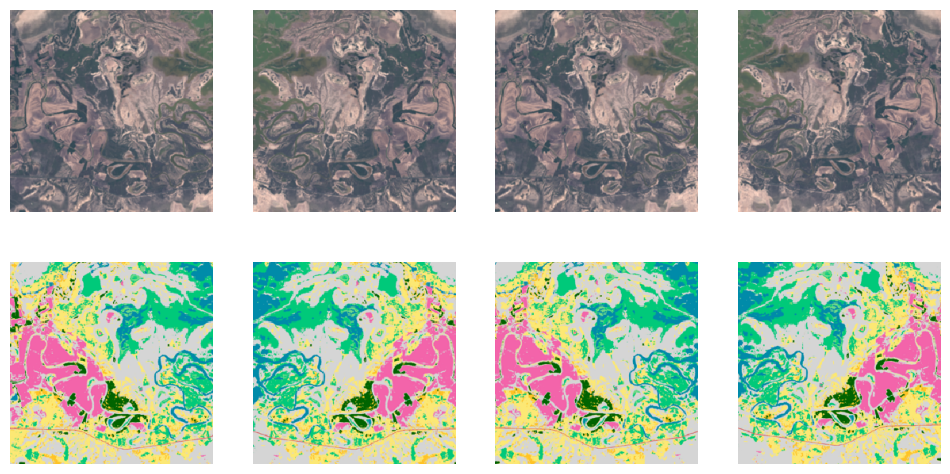

In [6]:
# The satellite training set consist of 1000 images
BUFFER_SIZE = 1000
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

plt.figure(figsize=(12, 12))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(1, 4, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
  plt.subplot(2, 4, i + 1)
  plt.imshow(rj_re / 255.0)
  plt.axis('off')

plt.show()

In [7]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [8]:
all_path = '24-1204_training_images_2'
train_dataset = tf.data.Dataset.list_files(str(all_path + '/training/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
    test_dataset = tf.data.Dataset.list_files(str(all_path +'/test/*.png'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(all_path + '/validation/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Step 2

<strong style="color: #CD6AA3;">The main part of model building process</strong> is scraped from [this Kaggle project by Khaled Sayed](https://www.kaggle.com/code/khaledsayedaaaaa/image-to-image-translation-with-a-conditional-gan), where it uses 400 256X256 pixel images to translate colored blocks representation of façade to actual façade image. We take a similar approach by training on 256X256 pixel land cover/satellite images. Empirically speaking, GAN model doesn’t really work well beyond this scale.

## Step 3

<strong style="color: #CD6AA3;">We begin with building a generator</strong> – one of the two major components of a GAN model. We first define a downsampler which translates the spatial dimension of images to “depth” of image and a upsampler which does vice versa. We then combine these two processes to make the generator capable of downsampling land cover images and upsampling to a satellite image with learned convolutional filters. We can examine the structure of this generator by running tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64), while the generator_loss() function helps us examine the performance of generator (the loss should be as small as possible as long as keeping a balance with discriminator loss).

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [10]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [11]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

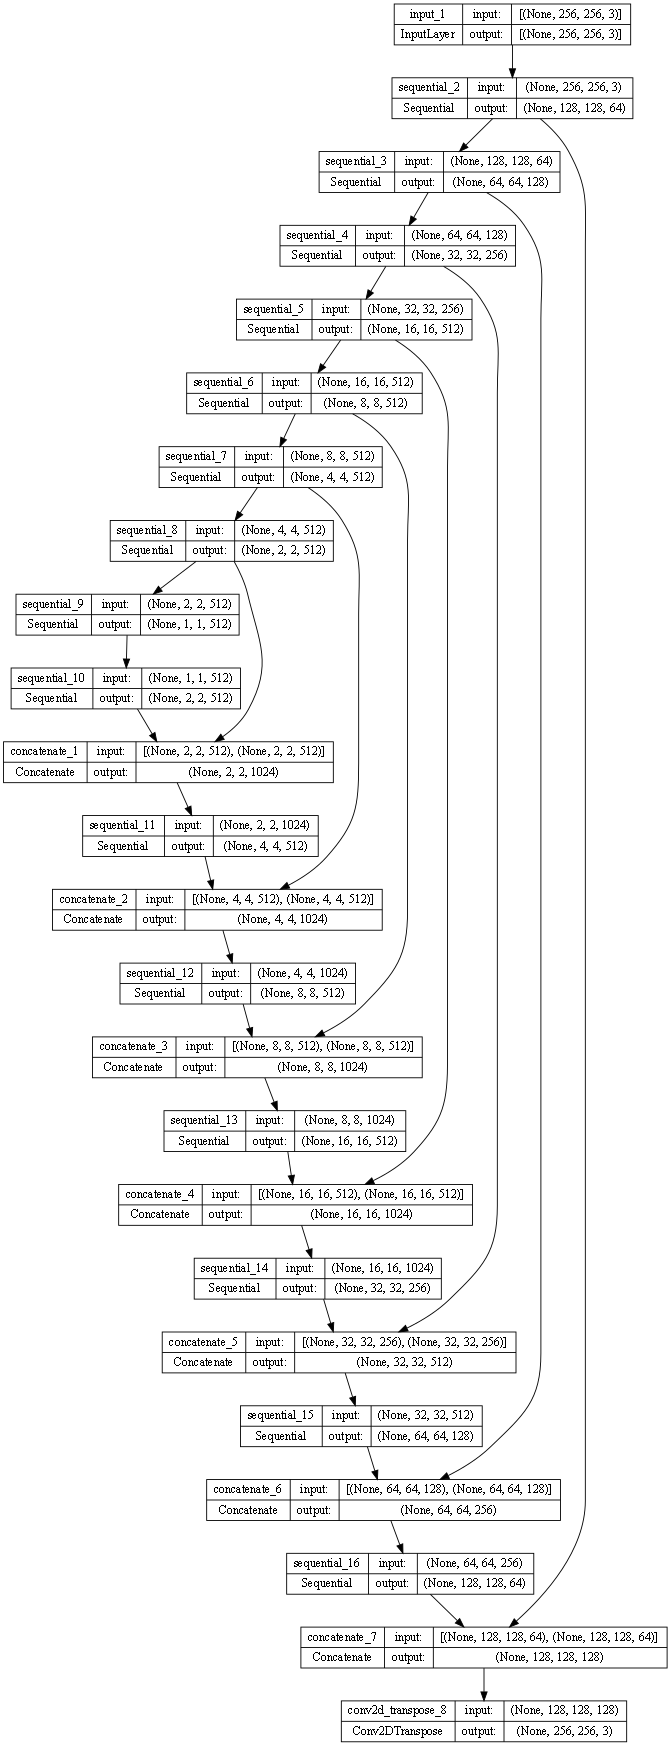

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [13]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

<div style="border-left: 4px solid #f00; padding: 0.5em; background-color: #fdd; margin-top:0.5em; margin-bottom: 0.5em;">
<strong>Please refer to:</strong> <br> [Learning AI If You Suck at Math Part 4 - Tensor Illustrated With Cats](https://resources.experfy.com/ai-ml/learning-ai-if-you-suck-at-math-part4-tensors-illustrated-with-cats/) and [Part 5 - Deep Learning and Convolutional Neural Nets in Plain English by Daniel Jeffries](https://resources.experfy.com/ai-ml/learning-ai-if-you-suck-at-math-part5-deep-learning-and-convolutional-neural-nets-in-plain-english/) for more knowledge on convolutional layers.
</div>

## Step 4

<strong style="color: #CD6AA3;">Then, we build another major component of GAN model – discriminator.</strong> This function enables the model downsamples the input image (a concatenation of land cover and satellite image in 2 channels) and predicts whether the generated image is real or fake. Likewise, the tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64) command can be used to examine the structure of this discriminator and discriminator_loss() function can record the performance of discriminator during each iteration of training.

In [14]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

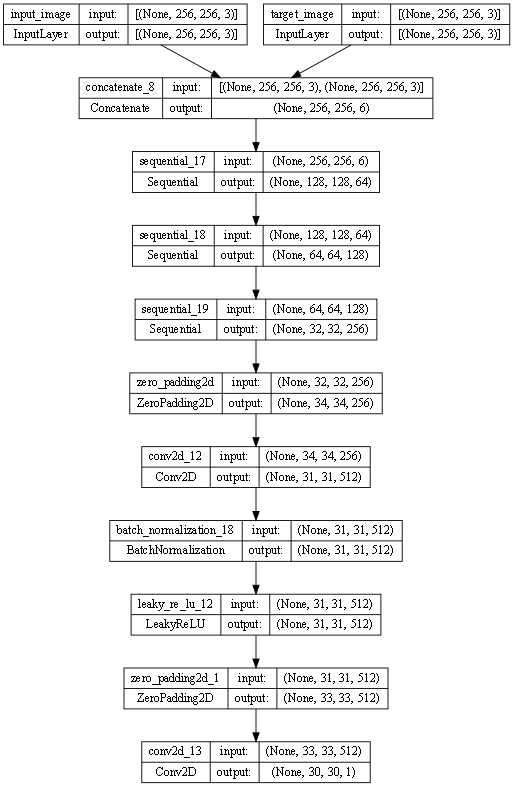

In [15]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

## Step 5

<strong style="color: #CD6AA3;">After this step, we add optimizer parameters</strong> (adjusting model’s learning rate) and training checkpoints to allow intervals in training. Training checkpoints are saved at checkpoint_dir.

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = '24-1204_Pix2Pix_3/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 6

<strong style="color: #CD6AA3;">Finally, we build a function that allows us to check the training progress over training iterations.</strong> This function will save original land cover and satellite images along with generated satellite images side by side for every image in test_dataset.

In [18]:
def generate_images(model, test_input, tar, save_dir, prefix='image', max_images=100):
    os.makedirs(save_dir, exist_ok=True)
    
    test_input = tf.squeeze(test_input, axis=1)
    tar = tf.squeeze(tar, axis=1)

    predictions = model(test_input, training=True)

    num_images = min(test_input.shape[0], max_images)

    for i in range(num_images):
        plt.figure(figsize=(15, 5))

        display_list = [test_input[i], tar[i], predictions[i]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.title(title[j])
            plt.imshow(display_list[j] * 0.5 + 0.5)
            plt.axis('off')

        image_path = os.path.join(save_dir, f'{prefix}_{i}.png')
        plt.savefig(image_path)
        plt.close()

## Step 7

<strong style="color: #CD6AA3;">After building the model, we use the model to train on our land cover and satellite data.</strong> For each 10 steps(training 10 BATCH_SIZE of images), the fit() function prints a dot; for each 1000 steps, the fit() function prints training time and generator/discriminator loss after each 1000 step, while images generated by the newest model are saved at save_dir; for each 5000 steps, the model saves at checkpoint folder.

In [21]:
log_dir = '24-1204_Pix2Pix_3/logs/'

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [22]:
gen_gan_loss_list = []
gen_l1_loss_list = []
gen_total_loss_list = []
disc_loss_list = []
data = 0
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
        tf.summary.scalar('disc_loss', disc_loss, step=step)

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [23]:
def fit(train_ds, test_ds, steps):
    from builtins import enumerate  
    example_input, example_target = next(iter(test_ds.batch(45).take(1)))
    start = time.time()

    for step, (input_image, target) in enumerate(train_ds.repeat().take(steps)):
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target)

        if step % 1000 == 0:
            if step != 0:
                print(f'\nTime taken for 1000 steps: {time.time() - start:.2f} sec\n')
                # Print the losses
                print('Discriminator loss:', disc_loss.numpy())
                print('Generator GAN loss:', gen_gan_loss.numpy())
                print('Generator L1 loss:', gen_l1_loss.numpy())
                print('Generator total loss:', gen_total_loss.numpy())
            start = time.time()

            save_dir = './24-1204_Pix2Pix_3/generated_images' 
            generate_images(generator, example_input, example_target, save_dir, prefix=f'step_{step}')
            print(f"Step: {step // 1000}k")

        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)

        try:
            if (step + 1) % 5000 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)
        except UnicodeDecodeError as e:
            print(f"Checkpoint save error: {e}")

        #with summary_writer.as_default():
            #tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
            #tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
            #tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
            #tf.summary.scalar('disc_loss', disc_loss, step=step)

In [ ]:
#| eval: false

fit(train_dataset, test_dataset, steps=40000)

<strong style="color: #CD6AA3;">We can also check generated images</strong> by the final model and save the final model by running following commands:

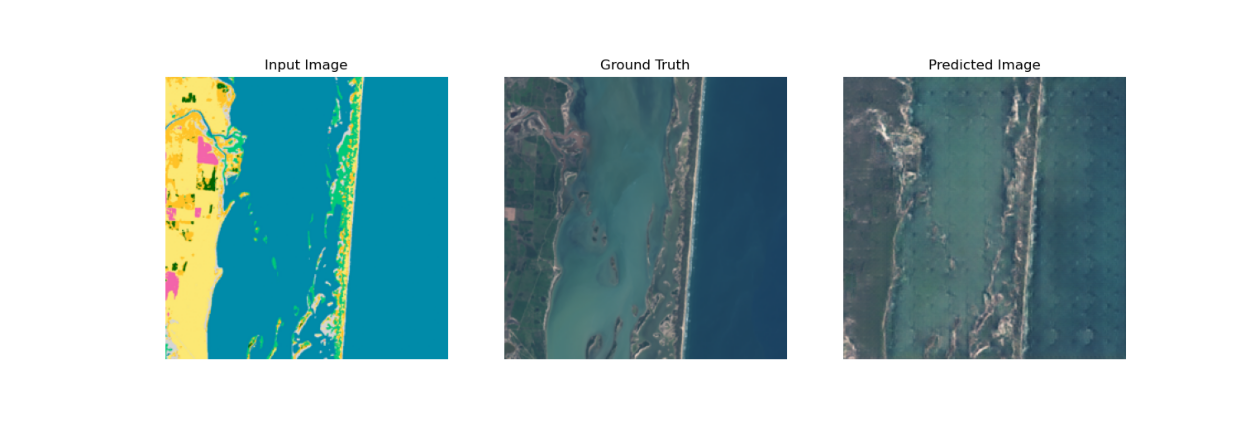

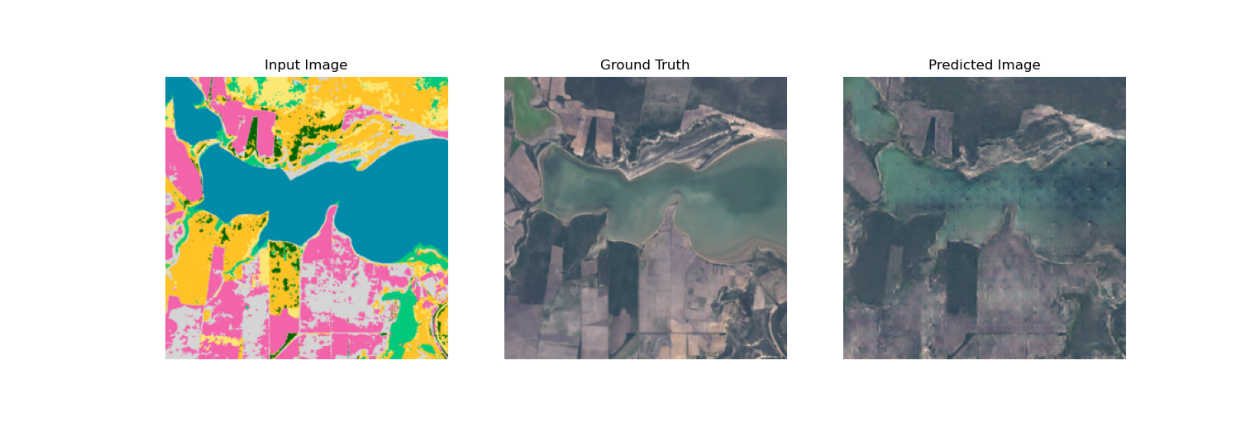

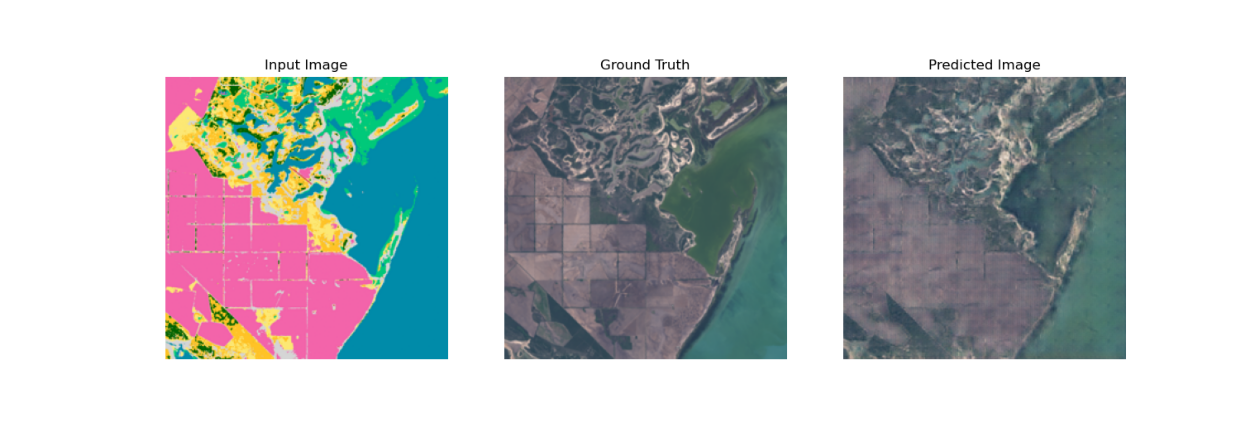

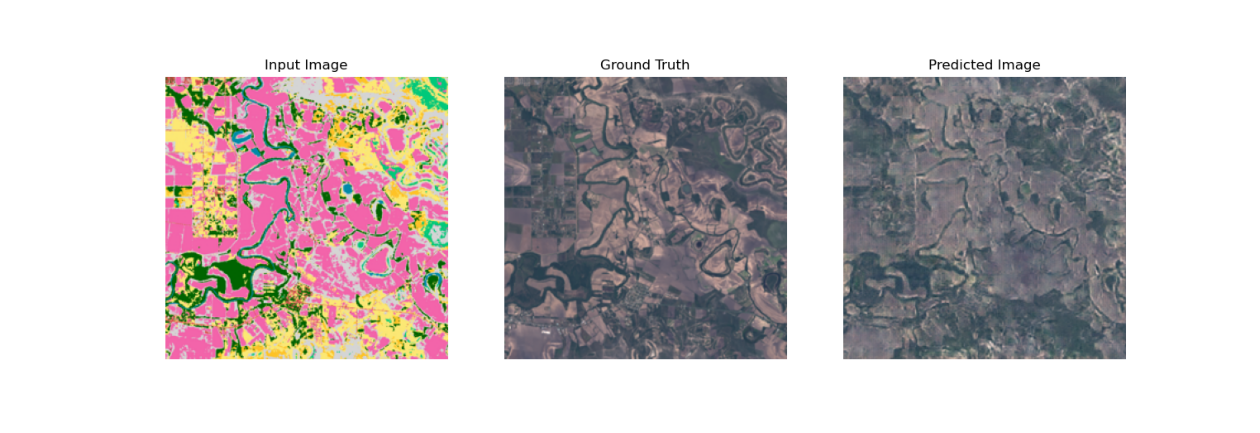

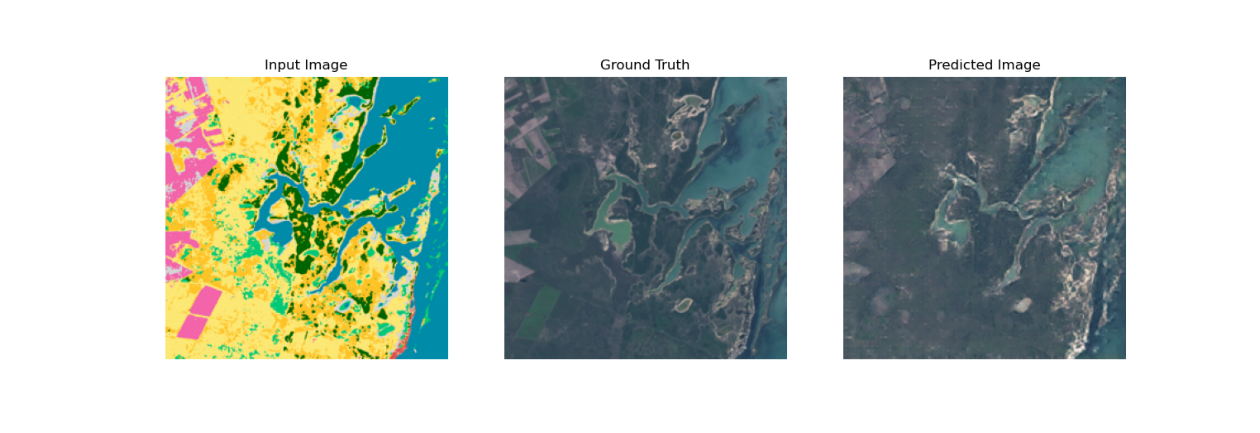

In [31]:
generation_files = [file for file in os.listdir('24-1204_Pix2Pix_3/generated_images') if file.endswith(('.png', '.jpg', '.jpeg')) and file.startswith('step_39000')]

for i, filename in enumerate(generation_files[:5]):
    img_path = os.path.join('./24-1204_Pix2Pix_3/generated_images', filename)
    img = Image.open(img_path)

    fig, ax = plt.subplots(figsize=(16, 8)) 
    ax.imshow(img)
    ax.axis('off') 
    plt.show()

In [ ]:
#| eval: false

generator.save('./24-1204_Pix2Pix_3/model.h5')

<strong style="color: #CD6AA3;">The following graphs show the running time and model performance from one of my training session.</strong> As Model Performance Metrics graph shows, the Generator L1 Loss, or the pixel-wise absolute difference between the generated image and the ground-truth image, stables at a lower level, inidcating that trained images have high resemblance to their ground truth images; generator GAN loss and discriminator loss fluctuates at a higher level, reflecting the adversarial nature of the training process, where the generator and discriminator continually compete. This competition leads to fluctuations as the generator tries to fool the discriminator, and the discriminator strives to distinguish real images from generated ones.

The Training Time graph shows that each 1,000 step in training takes about 125 seconds, regardless of the progression of the training. In total, a 39,000-step training session with 1,000 images would generally take 81 minutes to complete.

In [64]:
data = {
    "Step": [],
    "Time": [],
    "Discriminator Loss": [],
    "Generator GAN Loss": [],
    "Generator L1 Loss": [],
    "Generator Total Loss": []
}

with open('24-1204_Pix2Pix_3/logs/logs.txt', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 8):
        step_line = lines[i].strip()
        time_line = lines[i + 2].strip()
        disc_loss_line = lines[i + 4].strip()
        gen_gan_loss_line = lines[i + 5].strip()
        gen_l1_loss_line = lines[i + 6].strip()
        gen_total_loss_line = lines[i + 7].strip()

        step = int(step_line.split(':')[1].replace('k', '000'))
        time = float(time_line.split(': ')[1].split()[0])
        disc_loss = float(disc_loss_line.split(': ')[1])
        gen_gan_loss = float(gen_gan_loss_line.split(': ')[1])
        gen_l1_loss = float(gen_l1_loss_line.split(': ')[1])
        gen_total_loss = float(gen_total_loss_line.split(': ')[1])

        data["Step"].append(step)
        data["Time"].append(time)
        data["Discriminator Loss"].append(disc_loss)
        data["Generator GAN Loss"].append(gen_gan_loss)
        data["Generator L1 Loss"].append(gen_l1_loss)
        data["Generator Total Loss"].append(gen_total_loss)

df = pd.DataFrame(data)

chart1 = alt.Chart(df).mark_line(point=True).encode(
    x=alt.X('Step', title='Training Step'),
    y=alt.Y('Time', title='Time Taken (sec)'),
    tooltip=['Step', 'Time']
).properties(
    title='Training Time Per 1,000 Steps',
    width=900,  
    height=450
)

chart2 = alt.Chart(df.melt('Step', var_name='Metric', value_name='Value')).transform_filter(
    alt.datum.Metric != 'Time' 
).transform_filter(
    alt.datum.Metric != 'Generator Total Loss' 
).mark_line(point=True).encode(
    x=alt.X('Step', title='Training Step'),
    y=alt.Y('Value', title='Loss Values'),
    color='Metric',
    tooltip=['Step', 'Metric', 'Value']
).properties(
    title='Model Performance Metrics',
    width=900,  
    height=450
)

chart2 & chart1


alt.VConcatChart(...)